In [37]:
#!unzip '/content/hw3.zip'

Archive:  /content/hw3.zip
replace HW3.tex? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

#Implementing Random Forest Algorithm

In this section we: </br>
* Reused our previous DT implementation but adjusting it so it handles both categorical and numerical data. Also Implemented a mechanism to select (whenever a node is being split) m attributes at random from
the complete set of attributes of an instance where m ≈√X; X is
the total number of attributes composing each instance in the dataset
* Implemented a procedure to create bootstrap datasets by sampling with replacement
* Implemented the stratified cross-validation technique.
* Created a method to evaluate the impact that the number of trees (i.e., the ntree hyper-parameter) has on the performance of your random forest.


In [49]:
class DT:
    def __init__(self, max_depth=10, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def entropy(self, labels):
        label, counts = np.unique(labels, return_counts=True)
        prob = counts / counts.sum()
        return -np.sum(prob * np.log2(prob))

    def information_gain_numerical(self, labels, true_labels, false_labels):
        prob = float(len(true_labels)) / len(labels)
        info_gain = self.entropy(labels) - prob * self.entropy(true_labels) - (1 - prob) * self.entropy(false_labels)
        return info_gain

    def information_gain_categorical(self, labels, partitions):
        values, counts = np.unique(partitions, return_counts=True)
        avg_entropy_of_partitions = sum((counts[i] / sum(counts)) * self.entropy(labels[partitions == value]) for i, value in enumerate(values))
        return self.entropy(labels) - avg_entropy_of_partitions

    def best_split(self, features, labels, feature_types, min_info_gain=0.01):
        best_gain = -np.inf
        best_feature = None
        best_split_val = None
        m = int(math.sqrt(len(features.columns)))
        m_features = np.random.choice(features.columns, m, replace=False)
        for feature in m_features:
            if feature_types[feature] == "categorical":
                info_gain = self.information_gain_categorical(labels, features[feature])
                if info_gain > best_gain and info_gain >= min_info_gain:
                    best_gain, best_feature = info_gain, feature
                    best_split_val = None
            else:
                sorted_indices = features[feature].sort_values().index
                sorted_labels = labels.loc[sorted_indices]
                sorted_features = features.loc[sorted_indices, feature]
                for i in range(1, len(sorted_features)):
                    if sorted_features.iloc[i] == sorted_features.iloc[i - 1]:
                        continue
                    split_val = (sorted_features.iloc[i] + sorted_features.iloc[i - 1]) / 2
                    true_labels = sorted_labels[sorted_features <= split_val]
                    false_labels = sorted_labels[sorted_features > split_val]
                    info_gain = self.information_gain_numerical(labels, true_labels, false_labels)
                    if info_gain > best_gain and info_gain >= min_info_gain:
                        best_gain, best_feature, best_split_val = info_gain, feature, split_val
        return best_feature, best_split_val

    def build_dt(self, features, labels, feature_types, depth=0):
        if len(np.unique(labels)) == 1 or len(features) < self.min_samples_leaf or (self.max_depth and depth >= self.max_depth):
            return np.unique(labels)[0]
        else:
            best_feature, best_split_val = self.best_split(features, labels, feature_types)
            if best_feature is None:
                return np.unique(labels)[np.argmax(np.unique(labels, return_counts=True)[1])]
            tree = {best_feature: {}}
            if best_split_val is None:
                for value in np.unique(features[best_feature]):
                    subtree_features = features[features[best_feature] == value].drop(columns=[best_feature])
                    subtree_labels = labels[features[best_feature] == value]
                    subtree = self.build_dt(subtree_features, subtree_labels, feature_types, depth + 1)
                    tree[best_feature][value] = subtree
            else:
                left_indices = features[best_feature] <= best_split_val
                right_indices = features[best_feature] > best_split_val
                left_subtree = self.build_dt(features[left_indices], labels[left_indices], feature_types, depth + 1)
                right_subtree = self.build_dt(features[right_indices], labels[right_indices], feature_types, depth + 1)
                tree[best_feature] = {"<= {:.2f}".format(best_split_val): left_subtree , "> {:.2f}".format(best_split_val): right_subtree}
            return tree

    def fit(self, features, labels, feature_types):
        self.feature_types = feature_types
        self.tree = self.build_dt(features, labels, feature_types)

    def predict(self, dataset):
        predictions = []
        for _, instance in dataset.iterrows():
            prediction = self.predict_helper(instance, self.tree)
            predictions.append(prediction)
        return np.array(predictions)

    def predict_helper(self, instance, tree):
        if not isinstance(tree, dict):
            return tree
        feature = next(iter(tree))
        if self.feature_types[feature] == 'categorical':
            if instance[feature] in tree[feature]:
                return self.predict_helper(instance, tree[feature][instance[feature]])
        else:
            for key, subtree in tree[feature].items():
                if key.startswith('<='):
                    split_val = float(key.split('<= ')[1])
                    if instance[feature] <= split_val:
                        return self.predict_helper(instance, subtree)
                elif key.startswith('>'):
                    split_val = float(key.split('> ')[1])
                    if instance[feature] > split_val:
                        return self.predict_helper(instance, subtree)
                else:
                    if instance[feature] == key:
                        return self.predict_helper(instance, subtree)
        return np.nan



In [40]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_leaf=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def bootstrap(self, features, labels):
        num_samples = features.shape[0]
        indices = np.random.choice(num_samples, num_samples, replace=True)
        return features.iloc[indices], labels.iloc[indices]

    def fit(self, features, labels, feature_types):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DT(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            features_sample, labels_sample = self.bootstrap(features, labels)
            tree.fit(features_sample, labels_sample, feature_types)
            self.trees.append(tree)

    def predict(self, instances):
        tree_preds = [tree.predict(instances) for tree in self.trees]
        tree_preds = np.array(tree_preds).T
        majority_votes = [self.most_common_label(pred) for pred in tree_preds]
        return np.array(majority_votes)

    def most_common_label(self, pred):
        return Counter(pred).most_common(1)[0][0]

In [41]:
def stratified_cross_validation(features, labels, k=10):
    y = labels.to_numpy()
    label_indices = [np.where(y == label)[0] for label in np.unique(y)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

In [42]:
def unique_labels_filter(true_labels):
    filtered_labels = [label for label in true_labels if not np.isnan(label)]
    return np.unique(filtered_labels)

def mc_cm(true_labels, predictions, num_classes):
    unique_labels = unique_labels_filter(true_labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for true, pred in zip(true_labels, predictions):
        if np.isnan(pred):
            continue
        true_idx = label_to_index[true]
        pred_idx = label_to_index.get(pred, -1)
        if pred_idx != -1:
            confusion_matrix[true_idx][pred_idx] += 1
    return confusion_matrix

def metrics_calc(confusion_matrix):
    metrics = {'precision': [], 'recall': [], 'f1': []}
    for i in range(len(confusion_matrix)):
        TP = confusion_matrix[i][i]
        FN = sum(confusion_matrix[i][j] for j in range(len(confusion_matrix)) if j != i)
        FP = sum(confusion_matrix[j][i] for j in range(len(confusion_matrix)) if j != i)
        TN = sum(sum(confusion_matrix[j][k] for k in range(len(confusion_matrix)) if k != i) for j in range(len(confusion_matrix)) if j != i)
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        metrics['f1'].append(f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
    for metric in metrics:
        metrics[metric] = sum(metrics[metric]) / len(metrics[metric])
    return metrics


In [43]:
def evaluate_rf(features, labels, feature_types, k=10, ntree=1):
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    pairs = stratified_cross_validation(features, labels, k=k)
    num_classes = len(np.unique(labels))
    for train_indices, test_indices in pairs:
        features_train, labels_train = features.iloc[train_indices], labels.iloc[train_indices]
        features_test, labels_test = features.iloc[test_indices], labels.iloc[test_indices]
        ensemble = RandomForest(n_trees=ntree, max_depth=10, min_samples_leaf=1)
        ensemble.fit(features_train, labels_train, feature_types)
        predictions = ensemble.predict(features_test)
        confusion_matrix = mc_cm(labels_test.to_numpy(), predictions, num_classes)
        metrics = metrics_calc(confusion_matrix)
        accuracy = sum(confusion_matrix[i][i] for i in range(num_classes)) / sum(sum(row) for row in confusion_matrix)
        scores['accuracy'].append(accuracy)
        scores['precision'].append(metrics['precision'])
        scores['recall'].append(metrics['recall'])
        scores['f1'].append(metrics['f1'])
    avg_perf = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_perf


#Analyzing The 1984 United States Congressional Voting Dataset

The goal, here, is to predict the
party (Democrat or Republican) of each U.S. House of Representatives Congressperson. The dataset is
composed of 435 instances. Each instance is described by 16 categorical attributes, and there are 2
classes.


In [44]:
voting_dataset = pd.read_csv('datasets/hw3_house_votes_84.csv')
voting_dataset.head()

,#handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-adi,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,class
0,1,2,1,2,2,2,1,1,1,2,0,2,2,2,1,2,1
1,1,2,1,2,2,2,1,1,1,1,1,2,2,2,1,0,1
2,0,2,2,0,2,2,1,1,1,1,2,1,2,2,1,1,0
3,1,2,2,1,0,2,1,1,1,1,2,1,2,1,1,2,0
4,2,2,2,1,2,2,1,1,1,1,2,0,2,2,2,2,0


In [45]:
voting_dataset.groupby('class').size()

class
0    267
1    168
dtype: int64

In [46]:
num_instances = len(voting_dataset)
num_instances

435

In [47]:
voting_features = voting_dataset.drop('class', axis=1)
voting_labels = voting_dataset['class']
voting_feature_types = {}
for column in voting_dataset.columns:
    if column == 'class':
        continue
    voting_feature_types[column] = 'categorical'
voting_feature_types

{'#handicapped-infants': 'categorical',
 'water-project-cost-sharing': 'categorical',
 'adoption-of-the-budget-resolution': 'categorical',
 'physician-fee-freeze': 'categorical',
 'el-salvador-adi': 'categorical',
 'religious-groups-in-schools': 'categorical',
 'anti-satellite-test-ban': 'categorical',
 'aid-to-nicaraguan-contras': 'categorical',
 'mx-missile': 'categorical',
 'immigration': 'categorical',
 'synfuels-corporation-cutback': 'categorical',
 'education-spending': 'categorical',
 'superfund-right-to-sue': 'categorical',
 'crime': 'categorical',
 'duty-free-exports': 'categorical',
 'export-administration-act-south-africa': 'categorical'}

**Using max_depth=10, min_samples_leaf=1 and min_info_gain=0.01 as stopping criterion**

In [48]:
average_performance_1 = evaluate_rf(voting_features, voting_labels, voting_feature_types, k=10, ntree=1)
print(f"Metrics for a value of ntree = {1}: {average_performance_1}")


Metrics for a value of ntree = 1: {'accuracy': 0.9392745418695503, 'precision': 0.9373634836275391, 'recall': 0.9364784648902296, 'f1': 0.9354331632774235}


In [35]:
ntree_values = [1, 5, 10, 20, 30, 40, 50]
metrics_results = {'ntree': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for ntree in ntree_values:
    average_performance = evaluate_rf(voting_features, voting_labels, voting_feature_types, k=10, ntree=ntree)
    metrics_results['ntree'].append(ntree)
    metrics_results['accuracy'].append(average_performance['accuracy'])
    metrics_results['precision'].append(average_performance['precision'])
    metrics_results['recall'].append(average_performance['recall'])
    metrics_results['f1'].append(average_performance['f1'])
    print(f"Metrics for a value of ntree = {ntree}: {average_performance}")


Metrics for a value of ntree = 1: {'accuracy': 0.9187580239764017, 'precision': 0.9193586235562989, 'recall': 0.9135293698676052, 'f1': 0.913751591700634}
Metrics for a value of ntree = 5: {'accuracy': 0.9518423437028088, 'precision': 0.9515718020226533, 'recall': 0.9506844938830232, 'f1': 0.9495117682040816}
Metrics for a value of ntree = 10: {'accuracy': 0.953521091311789, 'precision': 0.9512967032967035, 'recall': 0.9533109183844477, 'f1': 0.9515038701586981}
Metrics for a value of ntree = 20: {'accuracy': 0.9515730393637372, 'precision': 0.9502898335038429, 'recall': 0.9516313683593094, 'f1': 0.9490521110292791}
Metrics for a value of ntree = 30: {'accuracy': 0.9566042484647136, 'precision': 0.9535155249234197, 'recall': 0.9579525934305346, 'f1': 0.9545731141111544}
Metrics for a value of ntree = 40: {'accuracy': 0.9585523004127655, 'precision': 0.9583781451991659, 'recall': 0.9562814228255405, 'f1': 0.9561589282028489}
Metrics for a value of ntree = 50: {'accuracy': 0.953901137622

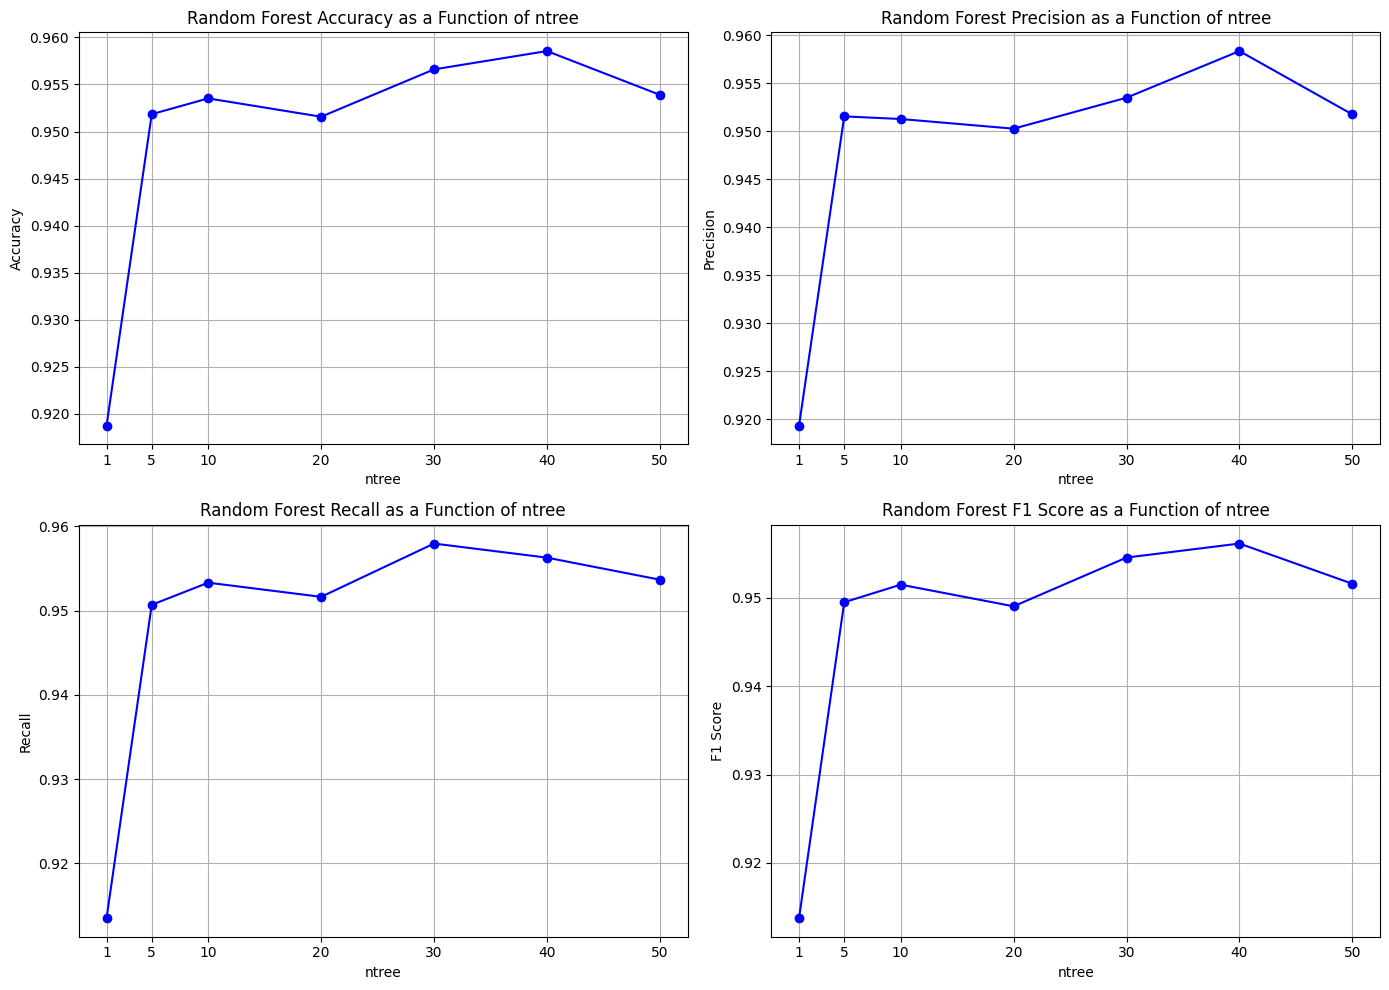

In [36]:
def plot(metrics):
    plt.figure(figsize=(14, 10))
    titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1'], start=1):
        plt.subplot(2, 2, i)
        plt.plot(metrics['ntree'], metrics[metric], marker='o', linestyle='-', color='b')
        plt.title(f'RF {titles[i-1]} as a function of ntree')
        plt.xlabel('ntree')
        plt.ylabel(titles[i-1])
        plt.xticks(metrics_results['ntree'])
        plt.grid(True)
    plt.tight_layout()
    plt.show()
plot(metrics_results)

**4.** For each metric being evaluated (and for each dataset), discuss which value of ntree you would
select if you were to deploy this classifier in real life. Explain your reasoning.

So in this notebook (section) we're dealing with The 1984 United States Congressional Voting Dataset. Based on the metric results obtained above for each value of ntree and loking at the plots generated our primary goal is to understand how the number of trees (ntree) affects key performance metrics such as accuracy, precision, recall, and F1 score. Let's discuss for each metric being evaluated what value of ntree we would select if we were to deplot this in real life:

Accuracy was observed to peak at ntree = 40 with a score of 0.958. After this point, increasing the number of trees seem to affect accuracy in a negative way (decreasing ). The value of accuracy for ntree = 30 is 0.956 which is really close to the the one for ntree = 40, however since it doesn't take too much mroe running time one could argue that it's worth the extra accuracy.  Hence for 40 the model's ability to correctly classify instances is the best. Accuracy is important because it provides us with a general measure of how often the classifier is correct across both classes. In our case for political prediction we should ensure that the model has a high accuracy and that its balanced across classes. Given that accuracy is and considering computational efficiency, ntree=40 appears to be a well-rounded choice for general purposes.

Precision was observed to peak at ntree = 40 with a score of 0.958. Precison measures how accurate the predicitons are when the model predicts a specific class. For instance, when predicting a Congressperson is a Democrat, precision tells us how many of those predicted as Democrats are actually Democrats. Thus, this metric is important when the consequences of FP  are significant. Targeting strategies based on incorrect party prediction could lead to wastage of resources, hence precision also matters and we should aim to maximize it as much as we can.  The running time doesn't take much longer while increasing ntree in this case, so I don't see the downside of choosing this ntree = 40 for value.

Recall was at its maximum at ntree = 30 with a score of 0.9579. Recall captures all relevant instances of a given class. For example, it gives us how many let's say of the actual Democrtas were correctly classified by our model. This is important in scenarios where missing out on a class instance has more consequences than missclassifying an instance.  However, this optimal point ntree = 30 for recall does not exactly match the optimal values identified for accuracy or precision, which peaked at ntree = 40. This discrepancy shows the tradeoff between ensuring that no party member is overlooked (high recall) and maintaining overall model accuracy and precision. I think that opting for a slightly higher ntree (40) might be a better choice if we were to deploy this in real life and in the context of voting even if  slight preference might be given to recall to ensure comprehensive coverage of party members given the political implications. This approach leverages the benefits of higher accuracy and precision provided by more trees while accepting a very small compromise in recall. The model remains robust across all metrics.

The F1 score, which balances precision and recall, peaked at ntree = 40 with a score of 0.956. Hence, ntree = 40 is indeed the best choice in this case: it ensures a balanced and fair tradeoff between precision and recall. The running time doesn't take much longer while increasing ntree in this case, so I don't see the downside of choosing this for value.

To sum up, based on the analysis, ntree = 40 is the recommended value for deploying this classifier. This choice is supported by the somewhat highest performance across all evaluated metrics. Further increases in ntree may not justify the marginal gains across the metrics due to increased computational demand and even decrease in performance. Using too many trees >40 in this context risks overfitting, where the model becomes too complex, capturing noise making the model less generalizable

*5.* Discuss (on a high level) which metrics were more directly affected by changing the value of
ntree and, more generally, how such changes affected the performance of your algorithm. For
instance: was the accuracy of the random forest particularly sensitive to increasing ntree past a
given value? Was the F1 score a “harder” metric to optimize, possibly requiring a significant
number of trees in the ensemble? Is there a point beyond which adding more trees does not
improve performance—or makes the performance worse?


All metrics more or less were directly affected by changing the value of ntree. Both accuracy and precision showed improvements as ntree increased, up to ntree = 40. So we can say that adding more trees up to this threshold generally helps the model make more correct classifications and more reliable positive predictions. However, we saw that past this optimal point, those metrics decreased, showing that there is a ceiling when reached adding more trees becomes counterproductive.

Recall was somewhat slightly less sensitive to increases in ntree compared to accuracy and precision. The optimal point for recall was lower than that for accuracy and precision ntree = 30, suggesting that recall might be maximized with fewer trees. We can say minimizing FP or in other words recall, does not benefit as much from theincrease in the number of trees beyond a certain point.

The F1 score, which balances precision and recall, was optimized at ntree = 40 similar to precision and accuracy, we can possibly deduce that the F1 score might follow the trend of precision and accuracy more closely than recall in response to increasing ntree. (at leaast in our case).

The model starts to overfit for ntree > 40 capturing noise. It becomes less generalizable to new instances and leads to a decrease across all metrics. Also there is a  high computational cost that's not justified when it comes to performance gains. So, 40 is our threshhold here that  balances the tradeoff of being enough complex but not too complex so it's prone to overfitting.